In [1]:
import pathlib
import numpy as np
import healpy as hp
import skyproj
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import astropy.coordinates
from astropy import units as u
from scipy import stats
import galstreams #contains stream data
%matplotlib inline

CURRENT_DIR = pathlib.Path.cwd().resolve()
DATA_DIR = CURRENT_DIR.parent / 'data'

## Functions

In [2]:
def change_coord(m, coord):   
    """ Change coordinates of a HEALPIX mapc

    Parameters
    ----------
    m : map or array of maps
      map(s) to be rotated
    coord : sequence of two character
      First character is the coordinate system of m, second character
      is the coordinate system of the output map. As in HEALPIX, allowed
      coordinate systems are 'G' (galactic), 'E' (ecliptic) or 'C' (equatorial)

    Example
    -------
    The following rotate m from galactic to equatorial coordinates.
    Notice that m can contain both temperature and polarization.
    >>>> change_coord(m, ['G', 'C'])
    """
    # Basic HEALPix parameters
    npix = m.shape[-1]
    nside = hp.npix2nside(npix)
    ang = hp.pix2ang(nside, np.arange(npix))

    # Select the coordinate transformation
    rot = hp.Rotator(coord=reversed(coord))

    # Convert the coordinates
    new_ang = rot(*ang)
    new_pix = hp.ang2pix(nside, *new_ang)

    return m[..., new_pix]

 # from https://stackoverflow.com/questions/44443498/how-to-convert-and-save-healpy-map-to-different-coordinate-system

In [3]:
#plots the nearby galaxies (requires nbg.cat list of galaxies)

def plot_galaxies(sp, gals=None, glist=None, annotate=False, glabels=None,radec = False):
    """ plots all galaxies within 10 Mpc 
    (requires nbg.cat--- file with table of galaxies from Karachentsev et al)

    Parameters
    ----------
    sp : skyproj object
      map on which to plot the galaxies
    glist: list of integers
      list of indices for galaxies to label
      if None, plots the whole table
    glabels: list of strings
      labels for the galaxies
      if None, numbers them 1 to N
    Returns
    -------
    cbh : figure handle containing information needed to produce a colorbar 
    
    Example
    -------
    Plot all the galaxies on a predefined skyproj
    >>>> plot_galaxies(sp)
    """
    from matplotlib.colors import LogNorm
    import pandas as pd
    from astropy import units as u
    from astropy.coordinates import SkyCoord


    if gals is None:
    #read and process the table
        nbg, nbgs = read_galaxies()
        dists = nbg[' D (Mpc)']*u.Mpc
        norm = LogNorm(vmin=0.2,vmax=10)
        r = 80
    else:
        if 'RA J2000  ' in gals.keys():
            ras=[]
            decs=[]
            hms_str = ['h','m','s']
            dms_str = ['d','m','s']
            for i in range(len(gals)):
                ra_str=gals['RA J2000  '][i].split(' ')
                dec_str = gals['DEC J2000'][i].split(' ')
                ras.append("".join(x+y for x,y in zip(ra_str,hms_str)))
                decs.append("".join(x+y for x,y in zip(dec_str,dms_str)))
            nbgs=SkyCoord(ras,decs)
            dists = gals[' D (Mpc)']
            norm = LogNorm(vmin=0.2,vmax=10)
            r = 80
        else:
            nbgs=SkyCoord(gals['ra'].values*u.deg,gals['dec'].values*u.deg)
            dists = ((gals['distance'].values*u.kpc).to(u.Mpc)).value
            norm = LogNorm(vmin=15,vmax=350)
            r = 60
    #set up the colormap (log distance)
    cmap = plt.get_cmap('cividis')
    norm = LogNorm() #(vmin=0.2,vmax=10.)

    #plot the galaxies
    if glist is None:
        if radec:
            cbh = sp.scatter(nbgs.ra.value, nbgs.dec.value, c=dists,  edgecolors= "black", cmap=cmap, norm=norm, s=40)
        else:
            cbh = sp.scatter(nbgs.galactic.l.value, nbgs.galactic.b.value, c=dists,  edgecolors= "black", cmap=cmap, norm=norm, s=40)
    else:
        if radec:
            cbh = sp.scatter(nbgs.ra.value[glist], nbgs.dec.value[glist], c=dists[glist],  edgecolors= "black", cmap=cmap, norm=norm, s=40)
        else:            
            cbh = sp.scatter(nbgs.galactic.l.value[glist], nbgs.galactic.b.value[glist], c=dists[glist],  edgecolors= "black", cmap=cmap, norm=norm, s=40)
        #label the ones listed
        if annotate:
            if glabels is None:
                glabels = np.arange(1, len(glist)+1).astype('str')
            for i, l in enumerate(glabels):
                if radec:
                    theta_order = np.argsort(nbgs.ra.value[glist])
                    x,y = sp.proj(nbgs[glist[theta_order[i]]].ra.deg, nbgs[glist[theta_order[i]]].dec.deg)       
                else:
                    theta_order = np.argsort(nbgs.galactic.l.value[glist])
                    x,y = sp.proj(nbgs[glist[theta_order[i]]].galactic.l.deg, nbgs[glist[theta_order[i]]].galactic.b.deg)       
                
                theta = np.linspace(0, 2*np.pi,len(glist)+1)
                costh = np.cos(theta[i])
                sinth = np.sin(theta[i])
                #costh = 2 * np.random.rand() - 1
                #sgn = np.sign(2 * np.random.rand() - 1)
                xt, yt = r*costh, r*sinth
                sp.ax.annotate(l.strip(' '), (x,y), (xt,yt),textcoords='offset points',arrowprops=dict(arrowstyle='-',color='k'),va='top',ha='left')
        
    return cbh

In [4]:
def read_galaxies():
    """ reads list of all galaxies within 10 Mpc 
    (requires nbg.cat--- file with table of galaxies from Karachentsev et al)
      
    Returns
    -------
    nbg : pandas dataframe with table in it
    nbgs : list of skycoords for each galaxy 
    
    Example
    -------
    Plot all the galaxies on a predefined skyproj
    >>>> plot_galaxies(sp)
    """

    import pandas as pd
    #read and process the table
    nbg=pd.read_csv(DATA_DIR / 'nbg.cat',sep="|",usecols=range(1,13))
    ras=[]
    decs=[]
    hms_str = ['h','m','s']
    dms_str = ['d','m','s']
    for i in range(len(nbg)):
        ra_str=nbg['RA J2000  '][i].split(' ')
        dec_str = nbg['DEC J2000'][i].split(' ')
        ras.append("".join(x+y for x,y in zip(ra_str,hms_str)))
        decs.append("".join(x+y for x,y in zip(dec_str,dms_str)))
    nbgs= astropy.coordinates.SkyCoord(ras,decs)

    return nbg, nbgs

In [9]:
def get_footprint(coords = 'G'):
    import healpy as hp
    # Read maps with the "tiles" covered -- these are built from APT's outputs
    HLWAS_wide = hp.read_map(DATA_DIR / 'HLWAS_WIDE_0328_APT994_1024.fits.gz')
    HLWAS_medium = hp.read_map(DATA_DIR / 'HLWAS_MEDIUM_0328_APT994_1024.fits.gz')
    maps = [HLWAS_wide, HLWAS_medium]
    
    #combine maps
    combined_map = np.zeros_like(HLWAS_wide)
    for i, m in enumerate(maps):
        m[m==hp.UNSEEN] = 0.
        combined_map[m!=0] = (i+1)*1.0

    combined_map[combined_map <=0] = hp.UNSEEN # Fill back with UNSEEN

    if coords=='G':
        combined_map = change_coord(combined_map,['C','G'])
    
    return combined_map


In [6]:
def read_satellites():
    import pandas as pd
    nbglm=pd.read_csv(DATA_DIR / 'Roman_MW_Dwarf_Targets.csv')
    return nbglm

In [7]:
def select_galaxies_in_footprint(fp, nbg_coords, nbgs, maxdist=8.0):
    gn=[]
    gs=[]
    for i,sat in enumerate(nbg_coords):
        ipix = hp.ang2pix(hp.get_nside(fp),sat.galactic.l.value, sat.galactic.b.value,lonlat=True)
        if not fp[ipix]==hp.UNSEEN:
            if sat.galactic.b.value > 0:
                gn.append(i)
            else:
                gs.append(i)
    in_mw = set(np.where(nbgs[' D (Mpc)']<0.3)[0].astype(int))
    too_far = set(np.where(nbgs[' D (Mpc)']>maxdist)[0].astype(int))
    #remove MW satellites
    nbgs_north = set(gn)
    nbgs_south = set(gs)

    nbgs_in_hlwas_north = list(nbgs_north.difference(in_mw).difference(too_far))
    nbgs_in_hlwas_south = list(nbgs_south.difference(in_mw).difference(too_far))

    nbgs_in_hlwas_north.sort()
    nbgs_in_hlwas_south.sort()

    print(len(nbgs_in_hlwas_north),'galaxies in northern footprint')
    print(len(nbgs_in_hlwas_south),'galaxies in southern footprint')
    return nbgs_in_hlwas_north, nbgs_in_hlwas_south
    
def select_satellites_in_footprint(fp,nbglm):
    nbglm_in_hlwas_north=[]
    nbglm_in_hlwas_south=[]
    for i in range(len(nbglm)):
        coord = astropy.coordinates.SkyCoord(nbglm['ra'][i]*u.deg,nbglm['dec'][i]*u.deg)
        ipix = hp.ang2pix(hp.get_nside(fp),coord.galactic.l.value, coord.galactic.b.value,lonlat=True)
        if not fp[ipix]==hp.UNSEEN:
            if coord.galactic.b.value > 0:
                nbglm_in_hlwas_north.append(i)
            else:
                nbglm_in_hlwas_south.append(i)
    print(len(nbglm_in_hlwas_north),'satellites in northern footprint')
    print(len(nbglm_in_hlwas_south),'satellites in southern footprint')    
    return nbglm_in_hlwas_north, nbglm_in_hlwas_south

In [8]:
def plot_polar_projection(fp, gals, glist, whichpole, glabels=None, alph=1.0):

    
    # Create a custom colorbar for the 3 maps
    from matplotlib.colors import ListedColormap
    import matplotlib
    # Design the color mapping
    col_dict = {1: "palegreen", 
                2: "limegreen"}
    
    # Create a colormap from our list of colors
    cm = ListedColormap([col_dict[x] for x in col_dict.keys()])

    # Make patches for the legend
    patch_HLWAS_w = mpatches.Patch(color=col_dict[1], label='HLWAS WIDE')
    patch_HLWAS_m = mpatches.Patch(color=col_dict[2], label='HLWAS MEDIUM')
    
    # Define labels
    labels = np.array(["HLWAS WIDE", "HLWAS MEDIUM"])
    len_lab = len(labels)

    fig, ax = plt.subplots(figsize=(8,8))
    if whichpole == 'S':
        sp = skyproj.LaeaSkyproj(ax=ax, lat_0=-90.0, galactic=True, extent=[0,360, -90,-10])
        im, _, _, _ = sp.draw_hpxmap(fp, lon_range=(0,360), lat_range=(-90, -10), alpha=alph, vmin=1, vmax=3, cmap=cm, zoom=False)
    else:
        sp = skyproj.LaeaSkyproj(ax=ax, lat_0=90.0, galactic=True, extent=[0,360, 10,90])
        im, _, _, _ = sp.draw_hpxmap(fp, lon_range=(0,360), lat_range=(10,90), alpha=alph, vmin=1, vmax=3, cmap=cm, zoom=False)
    
    
    cbh = plot_galaxies(sp,gals, glist=glist,annotate=True,glabels=glabels)
    shandles=[patch_HLWAS_m,patch_HLWAS_w]
    handles, labels = sp.ax.get_legend_handles_labels()
    shandles.extend(handles)
    
    sp.legend(handles=shandles, loc='upper left', ncol=2,  fontsize=10, bbox_to_anchor=(0.0,0.0, 1.0, 0.05))
    
    sp.ax.tick_params(axis="x", labelsize=14)
    sp.ax.tick_params(axis="y", labelsize=14)
    cb=plt.colorbar(cbh, shrink=0.8)
    cb.set_label(label='Distance (Mpc)', size=16)
    cb.ax.tick_params(labelsize=16)
    plt.tight_layout(h_pad=0.1,w_pad=0.1)
    return fig 
    

## Plotting

In [9]:
combined_map = get_footprint()

In [10]:
nbgs, nbg_coords = read_galaxies()
nbglm = read_satellites()

In [11]:
nbgs_in_hlwas_north, nbgs_in_hlwas_south = select_galaxies_in_footprint(combined_map, nbg_coords, nbgs, maxdist=15.0)

10 galaxies in northern footprint
15 galaxies in southern footprint


In [12]:
nbglm_in_hlwas_north, nbglm_in_hlwas_south = select_satellites_in_footprint(combined_map,nbglm)

6 satellites in northern footprint
8 satellites in southern footprint


In [12]:
import pandas as pd

virgo = pd.read_csv(DATA_DIR / 'fnx_virgo_gals.csv')

In [13]:
from astropy import units as u
from astropy.coordinates import SkyCoord

vgals = SkyCoord(virgo['RA-s'][virgo['Dec']>-10],virgo['Dec-s'][virgo['Dec']>-10])
fgals = SkyCoord(virgo['RA-s'][virgo['Dec']<-10],virgo['Dec-s'][virgo['Dec']<-10])

In [14]:
from scipy.spatial import ConvexHull
from shapely import Polygon

vhull_buffer = 1.

vhull = ConvexHull(np.vstack([vgals.galactic.l.deg, vgals.galactic.b.deg]).T)
vhull.close()
vhull_edges = vhull.points[vhull.vertices]
vhull_poly = Polygon(vhull_edges)
vhull_buffer_poly = vhull_poly.buffer(vhull_buffer, quad_segs=8)
vhull_buffer_poly_edges = np.array(list(vhull_buffer_poly.boundary.coords))
vhull_buffer_poly_path = vhull_buffer_poly_edges[np.arange(vhull_buffer_poly_edges.shape[0]+1) % vhull_buffer_poly_edges.shape[0]]

fhull_buffer = 1.

fhull = ConvexHull(np.vstack([fgals.galactic.l.deg, fgals.galactic.b.deg]).T)
fhull.close()
fhull_edges = fhull.points[fhull.vertices]
fhull_poly = Polygon(fhull_edges)
fhull_buffer_poly = fhull_poly.buffer(fhull_buffer, quad_segs=8)
fhull_buffer_poly_edges = np.array(list(fhull_buffer_poly.boundary.coords))
fhull_buffer_poly_path = fhull_buffer_poly_edges[np.arange(fhull_buffer_poly_edges.shape[0]+1) % fhull_buffer_poly_edges.shape[0]]


ModuleNotFoundError: No module named 'shapely'

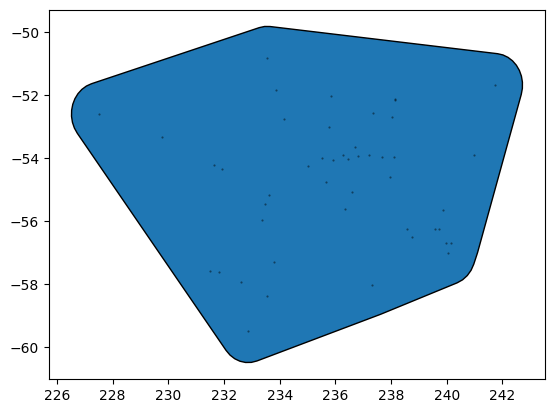

In [16]:
plt.plot(fgals.galactic.l.deg, fgals.galactic.b.deg,'.k',ms=1,alpha=0.5)

fhull_path = fhull_buffer_poly_path[np.arange(fhull_buffer_poly_path.shape[0]+1) % fhull_buffer_poly_path.shape[0]]
plt.gca().add_patch(mpatches.PathPatch(mpath.Path(fhull_path)))

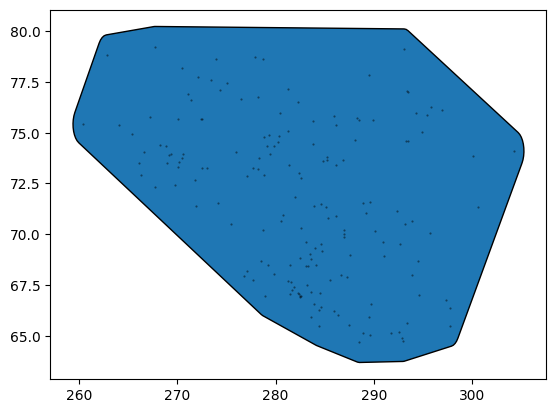

In [17]:
plt.plot(vgals.galactic.l.deg, vgals.galactic.b.deg,'.k',ms=1,alpha=0.5)

vhull_path = vhull_buffer_poly_path[np.arange(vhull_buffer_poly_path.shape[0]+1) % vhull_buffer_poly_path.shape[0]]
plt.gca().add_patch(mpatches.PathPatch(mpath.Path(vhull_path)))

/home/athob/miniconda3/envs/main/lib/python3.10/site-packages/skyproj/_skyproj.py:627: FutureWarning: skyproj.scatter() has been deprecated and will be removed in v2.5. Please access via skyproj.ax.scatter()
  warnings.warn(
/home/athob/miniconda3/envs/main/lib/python3.10/site-packages/skyproj/_skyproj.py:672: FutureWarning: skyproj.legend() has been deprecated and will be removed in v2.5. Please access via skyproj.ax.legend()
  warnings.warn(


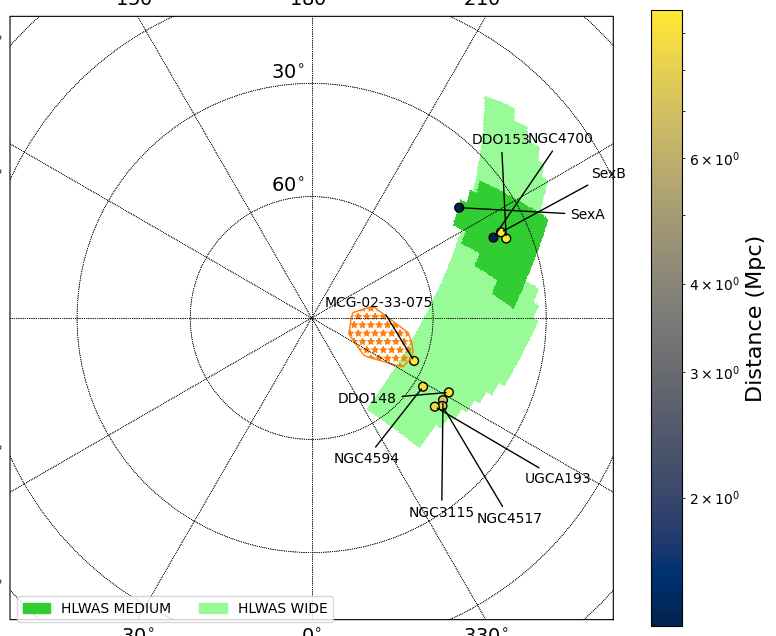

In [18]:
fig_gal_N = plot_polar_projection(combined_map,nbgs,
                                           nbgs_in_hlwas_north,
                                           'N',
                                           glabels=nbgs['Gal. Name    '][nbgs_in_hlwas_north])
# fig_gal_N.gca().plot(vgals.galactic.l.deg, vgals.galactic.b.deg,'sk',ms=5,alpha=0.1)
fig_gal_N.gca().add_patch(mpatches.PathPatch(mpath.Path(fig_gal_N.gca().projection.transform_points(*tuple(vhull_buffer_poly_path.T))), facecolor='tab:orange', edgecolor="tab:orange", fill=False, hatch='**'))

/home/athob/miniconda3/envs/main/lib/python3.10/site-packages/skyproj/_skyproj.py:627: FutureWarning: skyproj.scatter() has been deprecated and will be removed in v2.5. Please access via skyproj.ax.scatter()
  warnings.warn(
/home/athob/miniconda3/envs/main/lib/python3.10/site-packages/skyproj/_skyproj.py:672: FutureWarning: skyproj.legend() has been deprecated and will be removed in v2.5. Please access via skyproj.ax.legend()
  warnings.warn(


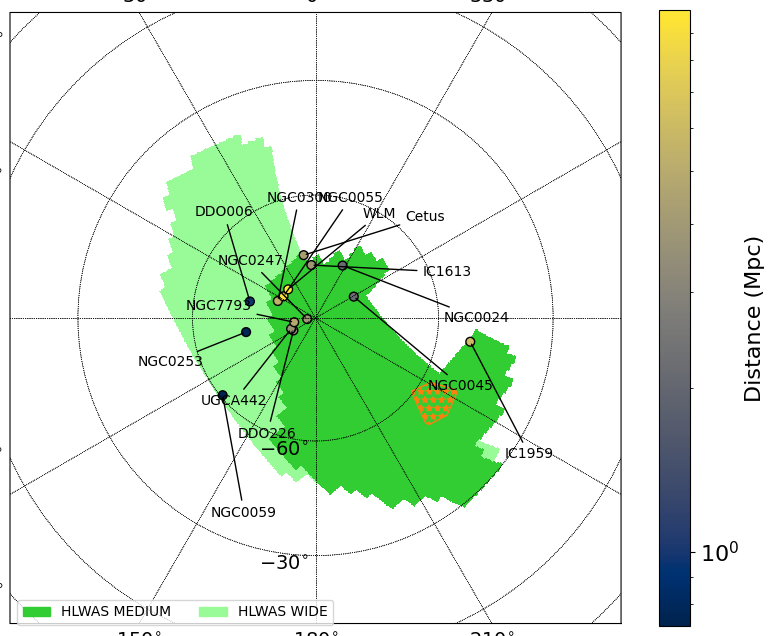

In [19]:
fig_gal_S = plot_polar_projection(combined_map,nbgs,nbgs_in_hlwas_south,'S',glabels=nbgs['Gal. Name    '][nbgs_in_hlwas_south])
# fig_gal_S.gca().plot(fgals.galactic.l.deg, fgals.galactic.b.deg,'sk',ms=5,alpha=0.1)
fig_gal_S.gca().add_patch(mpatches.PathPatch(mpath.Path(fig_gal_S.gca().projection.transform_points(*tuple(fhull_buffer_poly_path.T))), facecolor='tab:orange', edgecolor="tab:orange", fill=False, hatch='**'))

/home/athob/miniconda3/envs/main/lib/python3.10/site-packages/skyproj/_skyproj.py:627: FutureWarning: skyproj.scatter() has been deprecated and will be removed in v2.5. Please access via skyproj.ax.scatter()
  warnings.warn(
/home/athob/miniconda3/envs/main/lib/python3.10/site-packages/skyproj/_skyproj.py:672: FutureWarning: skyproj.legend() has been deprecated and will be removed in v2.5. Please access via skyproj.ax.legend()
  warnings.warn(


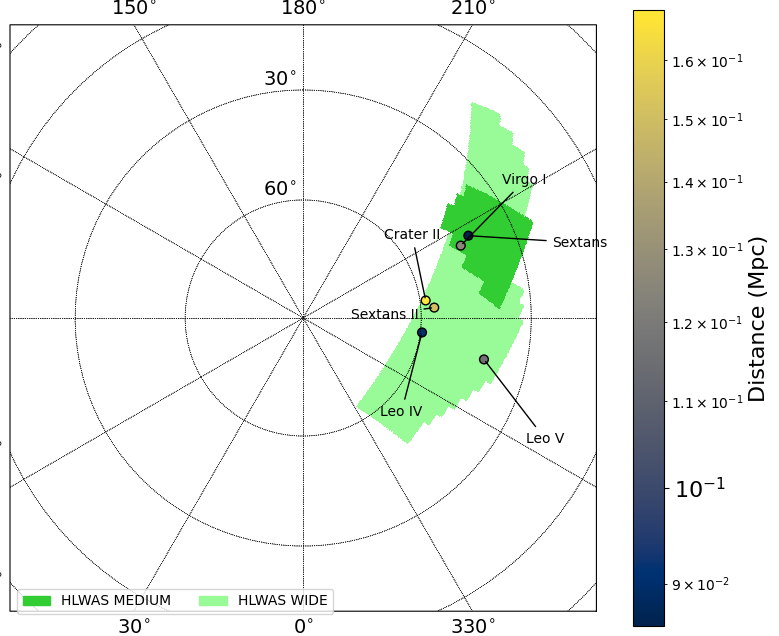

In [20]:
fig_sats_N = plot_polar_projection(combined_map, nbglm, nbglm_in_hlwas_north, 'N', nbglm['name'][nbglm_in_hlwas_north])

/home/athob/miniconda3/envs/main/lib/python3.10/site-packages/skyproj/_skyproj.py:627: FutureWarning: skyproj.scatter() has been deprecated and will be removed in v2.5. Please access via skyproj.ax.scatter()
  warnings.warn(
/home/athob/miniconda3/envs/main/lib/python3.10/site-packages/skyproj/_skyproj.py:672: FutureWarning: skyproj.legend() has been deprecated and will be removed in v2.5. Please access via skyproj.ax.legend()
  warnings.warn(


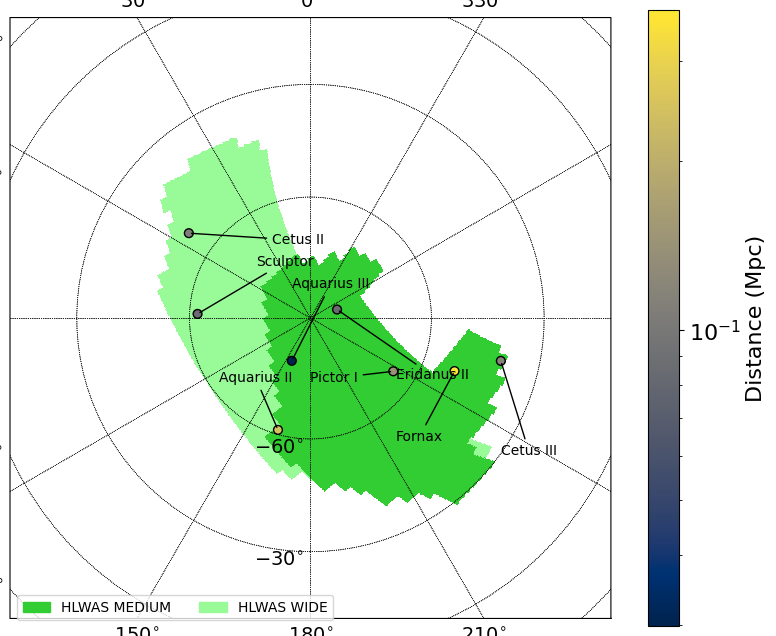

In [21]:
fig_sats_N = plot_polar_projection(combined_map, nbglm, nbglm_in_hlwas_south, 'S', nbglm['name'][nbglm_in_hlwas_south])


In [22]:
nbglm

,key,ra,dec,name,rhalf,distance,ellipticity,position_angle,M_V,apparent_magnitude_v,...,space_based_imaging,in_roman_wfs,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34
0,draco_2,238.198333,64.565278,Draco II,3.00,21.577444,0.23,76.0,-0.80,15.87,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,segue_1,151.750400,16.075600,Segue 1,3.62,22.908677,0.33,77.0,-1.30,15.50,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,tucana_3,359.107500,-59.583320,Tucana III,5.10,22.908677,0.20,25.0,-1.30,15.50,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,sagittarius_1,284.095166,-30.549887,Sagittarius,342.00,26.302680,0.64,102.0,-13.50,3.60,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,hydrus_1,37.389000,-79.308900,Hydrus I,7.42,27.542287,0.21,97.0,-4.71,12.49,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,pegasus_3,336.107417,5.415047,Pegasus III,1.67,214.783047,0.37,83.0,-4.17,17.49,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60,cetus_3,31.331000,-4.270000,Cetus III,1.23,251.188643,0.76,101.0,-3.45,18.55,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61,leo_1,152.114600,12.305900,Leo I,3.65,258.226019,0.30,78.0,-11.82,10.24,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62,eridanus_2,56.092500,-43.532900,Eridanus II,2.31,369.828180,0.48,72.6,-7.12,15.72,...,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
from matplotlib.colors import ListedColormap
import matplotlib
# Let's also design our color mapping: 1s should be plotted in blue, 2s in red, etc...
col_dict = {1: "palegreen", # "lightskyblue",
            2: "limegreen", # "dodgerblue",
            3: "firebrick"}

# We create a colormar from our list of colors
cm = ListedColormap([col_dict[x] for x in col_dict.keys()])

# Let's also define the description of each category : 1 (blue) is Sea; 2 (red) is burnt, etc... Order should be respected here ! Or using another dict maybe could help.
labels = np.array(["HLWAS WIDE", "HLWAS MEDIUM", "GPS"])
len_lab = len(labels)

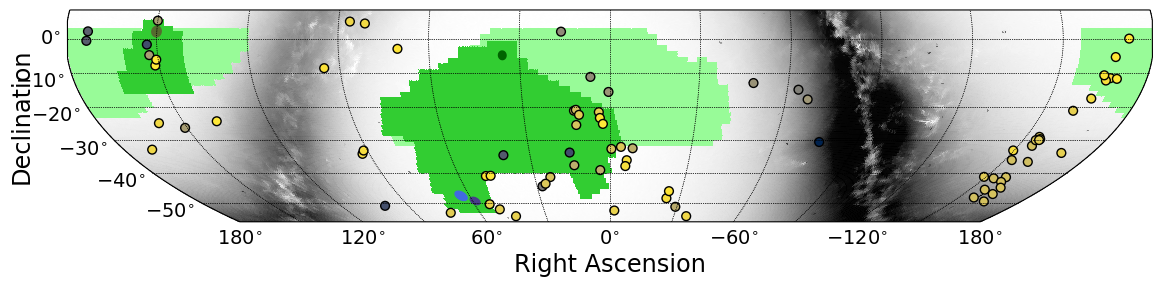

In [15]:
# read in healpix Gaia map
filename = DATA_DIR / 'gaia_stellar_density_map_G_21_gal_nside_128_v0.fits'
gaiamap = hp.read_map(filename)
gaiamap = change_coord(gaiamap, ['G', 'C'])
gaiamap -= np.min(gaiamap)
scale = np.std(gaiamap)*0.2
scaled_gmap = np.arcsinh(gaiamap/scale)

combined_map=get_footprint(coords='C')
#combined_map=change_coord(combined_map, ['G', 'C'])

alph=1.0

fig = plt.figure(1, figsize=(14, 10))
ax = fig.add_subplot(111)
sp = skyproj.sp = skyproj.McBrydeSkyproj(ax=ax, extent=[-180,180, -90, 90],  longitude_ticks='symmetric',galactic=False)
sp.draw_hpxmap(scaled_gmap,alpha=0.9,cmap='gray_r',vmin=0.5,vmax=5.0)


im, _, _, _ = sp.draw_hpxmap(combined_map, lon_range=(-180,180), lat_range=(-90, 90), alpha=alph, vmin=1, vmax=3, cmap=cm)

# Add coordinates for GTBDS and HLTDS
gbtds_one = astropy.coordinates.SkyCoord('17h50m16.8700s', '-28d41m11.10s')
gbtds_two = astropy.coordinates.SkyCoord('17h49m53.4700s','-28d49m31.00s')
elais_n1 = astropy.coordinates.SkyCoord('16h10m1.0000s', '+54d30m36.00s')
euclid_s_wide = astropy.coordinates.SkyCoord('04h14m24.0000s', '-47d36m0.00s')
euclid_s_deep = astropy.coordinates.SkyCoord('03h55m36.0000s', '-49d19m12.00s')
hlwas_cosmos = astropy.coordinates.SkyCoord('10h00m24.0000s', '+02d10m55.00s')
hlwas_xmm = astropy.coordinates.SkyCoord('02h22m50.0000s', '-04d45m0.00s')


# Add circles for the other surveys -- the size of the circles are kind of proportional to their footprints but it's not the actual size
#GBTDS
#sp.circle(gbtds_one.ra.value, gbtds_one.dec.value, 2.5/2, label='GBTDS', fill=True, alpha=alph, color='gold')
#HLTDS
sp.circle(elais_n1.ra.value, elais_n1.dec.value, 4./2, label='HLTDS ELAIS-N1', fill=True, alpha=alph, color='mediumblue')
sp.circle(euclid_s_wide.ra.value, euclid_s_wide.dec.value, 3.1/2, label='HLTDS EUCLID S WIDE', alpha=alph, fill=True, color='royalblue')
sp.circle(euclid_s_deep.ra.value, euclid_s_deep.dec.value, 2.5/2, label='HLTDS EUCLID S DEEP', alpha=alph, color='darkslateblue', fill=True)
#HLWAS DEEP
sp.circle(hlwas_cosmos.ra.value, hlwas_cosmos.dec.value, 3.1/2, label='HLWAS DEEP COSMOS', alpha=alph, fill=True, color='darkolivegreen')
sp.circle(hlwas_xmm.ra.value, hlwas_xmm.dec.value, 2.5/2, label='HLWAS DEEP XMM-LSS', alpha=alph, color='darkgreen', fill=True)

plot_galaxies(sp,radec=True)

#make legend

patch_HLWAS_w = mpatches.Patch(color=col_dict[1], label='HLWAS WIDE')
patch_HLWAS_m = mpatches.Patch(color=col_dict[2], label='HLWAS MEDIUM')
patch_GPS = mpatches.Patch(color=col_dict[3], label='GPS')


handles, labels = sp.ax.get_legend_handles_labels()
#handles.extend([patch_HLWAS_w, patch_HLWAS_m, patch_GPS])
shandles = handles[0:5]
shandles.extend([patch_HLWAS_m,patch_HLWAS_w])
shandles.extend([patch_GPS])
shandles.extend(handles[5:])

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

#sp.legend(handles=shandles, loc='lower center', ncol=4, bbox_to_anchor=(0, -0.35, 1.0, 0.55), fontsize=12)

sp.ax.tick_params(axis="x", labelsize=14)
sp.ax.tick_params(axis="y", labelsize=14)

plt.show();